In [2]:
import msprime
import sys
import numpy as np
import seaborn as sns
from IPython.display import SVG
import matplotlib.pyplot as plt
from itertools import chain

In [4]:
pop_configs = [
    msprime.PopulationConfiguration(sample_size=100, growth_rate = 0),
    msprime.PopulationConfiguration(sample_size=100, growth_rate = 0),
    msprime.PopulationConfiguration(sample_size=100, growth_rate = 0),]

divergence_event1 = msprime.MassMigration(time = 50, source = 1, dest = 0, proportion = 1)
divergence_event2 = msprime.MassMigration(time = 1000, source = 2, dest = 0, proportion = 1)
Ne = 100
recomb = 0.5
mutation_rate = 0.25
ts_ref = msprime.simulate(population_configurations = pop_configs,Ne = Ne,mutation_rate=mutation_rate,
                      demographic_events = [divergence_event1,divergence_event2],
                      random_seed = 1, recombination_rate = recomb)
pops = [range(0,100),range(100,200),range(100,200)]
ref_stats = (ts_ref.f3([pops[2],pops[0],pops[1]]),ts_ref.f2([pops[0],pops[1]]),ts_ref.diversity(),ts_ref.segregating_sites(),ts_ref.Tajimas_D())

In [6]:
#ABC Function
def Ts_stat_generator(pop_configs,pops,Ne,recomb,divergence2,mutations,prior ="exponential",prior_parameters=10,iters=1000):
    stats = [0]*iterations
    samples = [0]*iterations
    if prior == "exponential":
        for iter in range(0,iterations):
            divergence_time = min(np.random.exponential(prior_parameters),1000)
            divergence_event1 = msprime.MassMigration(time = divergence_time, source = 1, dest = 0, proportion = 1)
            ts_sim = msprime.simulate(population_configurations = pop_configs,Ne=Ne, mutation_rate=mutation_rate,
                      demographic_events = [divergence_event1,divergence2],recombination_rate = recomb)
            stats[iter]= (ts_sim.f3([pops[2],pops[0],pops[1]]),ts_sim.f2([pops[0],pops[1]]),ts_sim.diversity(),ts_sim.segregating_sites(),ts_sim.Tajimas_D())
            samples[iter] = divergence_time
    if prior == "uniform":
        for iter in range(0,iterations):
            divergence_time = min(np.random.uniform(prior_parameters[0],prior_parameters[1]),1000)
            divergence_event1 = msprime.MassMigration(time = divergence_time, source = 1, dest = 0, proportion = 1)
            ts_sim = msprime.simulate(population_configurations = pop_configs,Ne=Ne, mutation_rate=mutation_rate,
                      demographic_events = [divergence_event1,divergence2],recombination_rate = recomb)
            stats[iter]= (ts_sim.f3([pops[2],pops[0],pops[1]]),ts_sim.f2([pops[0],pops[1]]),ts_sim.diversity(),ts_sim.segregating_sites(),ts_sim.Tajimas_D())
            samples[iter] = divergence_time
    return(stats,samples)

In [8]:
%%time
#Exponential prior rate 40 
iterations = 10000
prior= "exponential"
prior_parameters = 40
attempt1 = Ts_stat_generator(pop_configs=pop_configs,pops=pops,Ne=Ne,recomb=recomb,divergence2=divergence_event2,mutations=mutation_rate,prior=prior,prior_parameters=prior_parameters,iters=iterations)

Wall time: 5min 27s


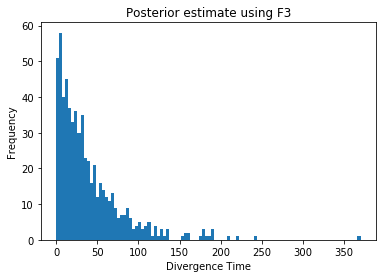

Acceptance probability : 0.0624


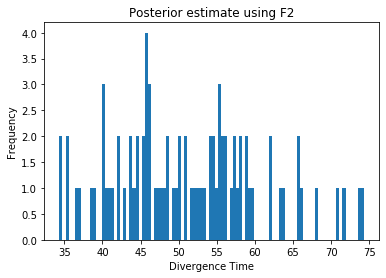

Acceptance probability : 0.0082


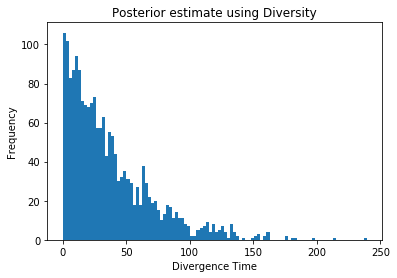

Acceptance probability : 0.1863


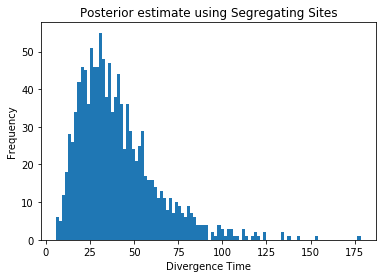

Acceptance probability : 0.1198


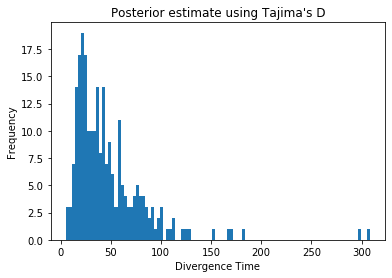

Acceptance probability : 0.0241


In [14]:
#Single Statistic Samples, eps = 0.1
stat_names = ["F3","F2","Diversity","Segregating Sites","Tajima's D"]
eps = 0.01
for i in range(len(ref_stats)):
    samples = []
    for j in range(iterations):
        sim_stat = attempt1[0][j][i]/ref_stats[i]
        if np.linalg.norm(np.subtract(sim_stat,1)) < eps:
            samples.append(attempt1[1][j])
    plt.hist(samples, bins = 100)
    plt.ylabel('Frequency')
    plt.xlabel('Divergence Time')
    plt.title('Posterior estimate using '+stat_names[i])
    plt.show()
    print("Acceptance probability :",len(samples)/iterations)

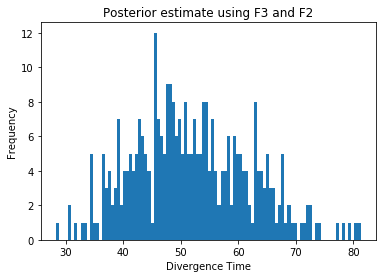

Acceptance probability : 0.0325


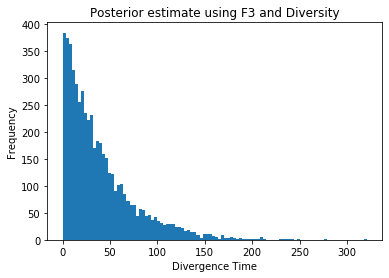

Acceptance probability : 0.5369


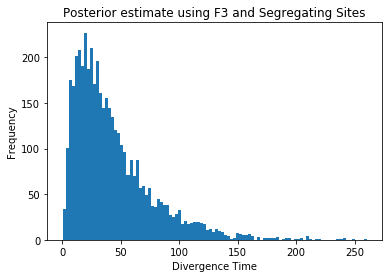

Acceptance probability : 0.4424


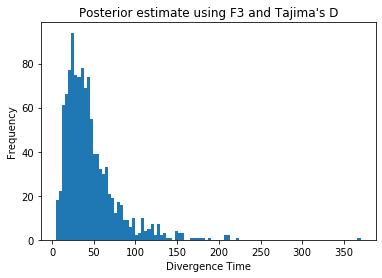

Acceptance probability : 0.1124


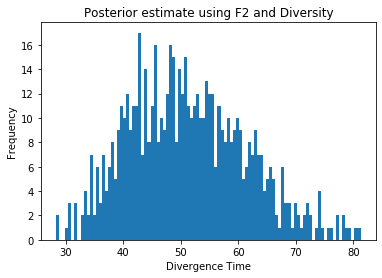

Acceptance probability : 0.0625


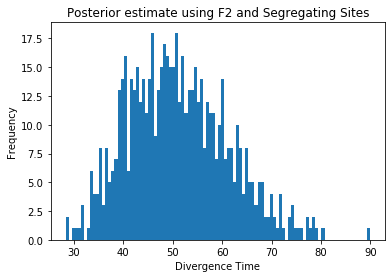

Acceptance probability : 0.063


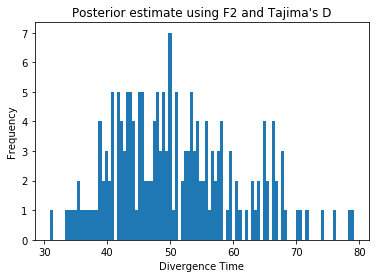

Acceptance probability : 0.0182


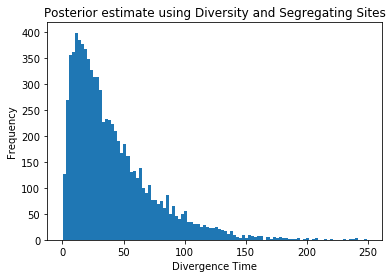

Acceptance probability : 0.8113


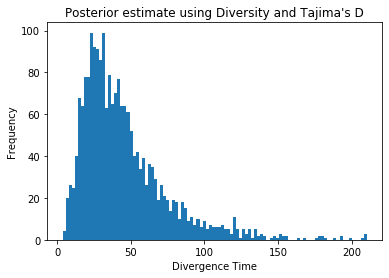

Acceptance probability : 0.2097


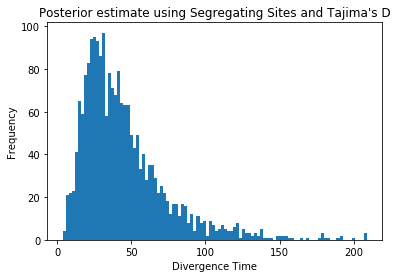

Acceptance probability : 0.2087


In [11]:
#Two Statistic Samples, eps = 0.1, standardised statistics
eps = 0.1
for i in range(len(ref_stats)):
    for j in range(i,len(ref_stats)):
        if i!=j:   
            samples = []
            for iteration in range(iterations):
                sim_stat = (attempt1[0][iteration][i]/ref_stats[i],attempt1[0][iteration][j]/ref_stats[j])
                if np.linalg.norm(np.subtract(sim_stat,(1,1))) < eps:
                    samples.append(attempt1[1][iteration])
            plt.hist(samples, bins = 100)
            plt.ylabel('Frequency')
            plt.xlabel('Divergence Time')
            plt.title('Posterior estimate using '+stat_names[i]+" and "+stat_names[j])
            plt.show()
            print("Acceptance probability :",len(samples)/iterations)